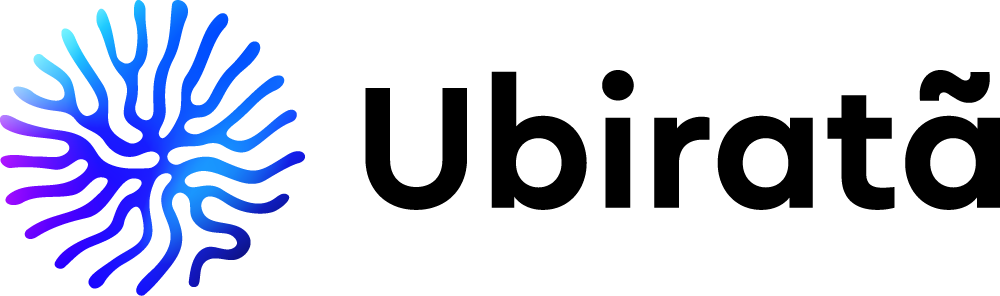

[Paleta de cores logo Ubiratã](https://coolors.co/ffffff-1738fe-57dcff-b7dcfe-9713ff-167bfc-1a9bfd)

**Estudo**

[Plot level sugarcane yield estimation by machine learning on multispectral images: A case study of Bundaberg, Australia](https://www.sciencedirect.com/science/article/pii/S2214317323000574?ref=pdf_download&fr=RR-2&rr=83818622f8c81aa1)

[Predicting the sugarcane yield in real-time by harvester engine parameters and machine learning approaches](https://www.sciencedirect.com/science/article/abs/pii/S0168169920331501?fr=RR-2&ref=pdf_download&rr=838833806d19a486)

# Bibliotecas

In [2]:
! pip install xgboost -U --quiet
! pip install scikit-optimize -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.0 MB/s eta 0:00:00


In [41]:
import  pandas as pd
import  numpy as np
import  plotly.express as px
import  plotly.graph_objects as go
import  xgboost as xgb
import  time
import  plotly.figure_factory as ff

from    google.colab import drive
from    statsmodels.stats.outliers_influence import variance_inflation_factor
from    sklearn.preprocessing import StandardScaler
from    sklearn.model_selection import (train_test_split,
                                        RandomizedSearchCV)
from    sklearn.metrics import (r2_score,
                                mean_squared_error,
                                mean_absolute_error,
                                max_error,
                                mean_absolute_percentage_error)
from    sklearn.ensemble import RandomForestRegressor
from    plotly.subplots import make_subplots
from    xgboost import plot_importance
from    scipy.stats import pearsonr

In [42]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
seed = 0

# Dataset

* bloco: índice da região de plantação e colheita de cana-de-açúcar
* talhao: índice da sub-região de plantação e colheita de cana-de-açúcar (Um bloco contém diversos talhões)
* area: área do talhão
* safra: ano que a cana-de-açúcar de cada talhão foi colhida
* data_colheita: data em que a cana-de-açúcar foi colhida
* TCH: Toneladas de cana-de-açúcar colhida por hectare
* NDVI_b01: NDVI é o nome dado a um popular índice de vegetação, e o “b01” corresponde ao índice no primeiro mês antes da colheita
* NDVI_bN: NDVI no N-ésimo mês antes da colheita

NDVI é a sigla para Índice de Vegetação da Diferença Normalizada (Normalized Difference Vegetation Index – do inglês).

É um índice usado para medir a saúde e a densidade da vegetação através de imagens de satélite, auxiliando no monitoramento das lavouras, e nas tomadas de decisão relacionadas ao manejo da cultura.

Este índice apresenta variação numérica de -1 a +1, sendo os valores positivos referentes ao vigor vegetativo da cultura, enquanto que os valores negativos indicam presença de água ou ausência de vegetação.

In [44]:
df = pd.read_csv('/content/drive/MyDrive/Teste Ubiratã/dataset_tch.csv',
                 sep=',',
                 encoding='utf-8')

df['data_colheita'] = pd.to_datetime(df['data_colheita'], format='%Y-%m-%d')

df.sort_values(by='data_colheita', inplace=True)

df.reset_index(drop=True, inplace=True)

df

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155


# a)
Faça uma rápida análise exploratória desse dataset, por exemplo análises estatísticas das variáveis, gráficos de distribuição, etc.

In [45]:
df['mil_tonelada_cana'] = df['area'] * df['TCH'] / 1000

df

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,6.603058
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477,7.670066
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876,6.765070
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389,3.097142
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534,9.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN


In [46]:
df_agrupado_safra_bloco = pd.DataFrame(df.groupby(['safra', 'bloco'])[['area', 'mil_tonelada_cana']].sum())

df_agrupado_safra_bloco.reset_index(drop=False, inplace=True)

df_agrupado_safra_bloco

,safra,bloco,area,mil_tonelada_cana
0,2014,5,64.51,9.024144
1,2014,8,328.38,24.135336
2,2014,11,97.08,10.787631
3,2014,12,215.81,27.389096
4,2014,13,67.28,5.585723
...,...,...,...,...
704,2019,463,552.85,0.000000
705,2019,464,264.29,0.000000
706,2019,468,150.14,0.000000
707,2019,473,219.79,0.000000


In [47]:
for safra in df_agrupado_safra_bloco['safra'].unique():
    df_safra_bloco = df_agrupado_safra_bloco[df_agrupado_safra_bloco['safra'] == safra]

    quantidade_blocos = df_safra_bloco['bloco'].value_counts().sum()

    milhao_tonelada_safra = df_safra_bloco['mil_tonelada_cana'].sum() / 1000

    print(f'Safra: {safra} - Blocos: {quantidade_blocos} - Total produzido: {milhao_tonelada_safra:.2f} milhões toneladas')

Safra: 2014 - Blocos: 154 - Total produzido: 2.27 milhões toneladas
Safra: 2015 - Blocos: 53 - Total produzido: 0.65 milhões toneladas
Safra: 2016 - Blocos: 27 - Total produzido: 0.34 milhões toneladas
Safra: 2017 - Blocos: 188 - Total produzido: 3.14 milhões toneladas
Safra: 2018 - Blocos: 172 - Total produzido: 3.45 milhões toneladas
Safra: 2019 - Blocos: 115 - Total produzido: 0.00 milhões toneladas


In [48]:
for nome_coluna, valores in df.items():
    if 'NDVI_b' in nome_coluna:

        hist_data = [valores]
        group_labels = [str(nome_coluna)]

        media = df[nome_coluna].mean()
        mediana = df[nome_coluna].median()

        fig = ff.create_distplot(hist_data,
                                 group_labels,
                                 show_hist=False,
                                 show_rug=False)

        fig.update_layout(height=400,
                          width=1200,
                          showlegend=False,
                          plot_bgcolor='#F9F9F9',
                          paper_bgcolor='#F9F9F9',
                          margin=dict(l=50,
                                      r=50,
                                      b=50,
                                      t=80,
                                      pad=10),
                          title='Distribuição de dados - ' + str(nome_coluna),
                          yaxis={'showgrid': True,
                                 'gridcolor': '#CBC9CD',
                                 'dtick': 0.5},
                          xaxis={'showgrid': False,
                                 'showticklabels': True})

        fig.add_vline(x=media, line_width=2, line_dash='dash',
                      line_color='green', annotation_text='Média',
                      annotation_font_color='green', annotation_position='top left')

        fig.add_vline(x=mediana, line_width=2, line_dash='dash',
                      line_color='red', annotation_text='Mediana',
                      annotation_font_color='red', annotation_position='bottom right')

        fig.show()

In [49]:
df['safra'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019])

In [50]:
df.shape

(1906, 19)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   bloco              1906 non-null   int64         
 1   talhao             1906 non-null   int64         
 2   area               1906 non-null   float64       
 3   safra              1906 non-null   int64         
 4   data_colheita      1906 non-null   datetime64[ns]
 5   TCH                1632 non-null   float64       
 6   NDVI_b01           1906 non-null   float64       
 7   NDVI_b02           1906 non-null   float64       
 8   NDVI_b03           1906 non-null   float64       
 9   NDVI_b04           1906 non-null   float64       
 10  NDVI_b05           1906 non-null   float64       
 11  NDVI_b06           1906 non-null   float64       
 12  NDVI_b07           1906 non-null   float64       
 13  NDVI_b08           1906 non-null   float64       
 14  NDVI_b09

In [52]:
df[df.isnull().any(axis=1)]

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,0.716843,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819,NaN
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,0.729465,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366,NaN
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,0.696446,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920,NaN
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,0.619985,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304,NaN
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,0.556784,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN


In [53]:
# Verifica dados null em safras diferente de 2019
df[(df.isnull().any(axis=1)) &
   (df['safra'] != 2019)].transpose()

""
bloco
talhao
area
safra
data_colheita
TCH
NDVI_b01
NDVI_b02
NDVI_b03
NDVI_b04


## 2014 a 2018

In [54]:
df_2014_2018 = df[df['safra'] != 2019].copy()

df_2014_2018

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,6.603058
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477,7.670066
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876,6.765070
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389,3.097142
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534,9.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,250,1,117.77,2018,2018-09-25,20.071738,0.426203,0.411605,0.468109,0.529646,0.619639,0.685097,0.682860,0.659134,0.572820,0.577737,0.500272,0.362951,2.363849
1628,395,3,36.02,2018,2018-09-25,21.880668,0.442258,0.421180,0.469074,0.532711,0.596744,0.660622,0.691889,0.556852,0.535244,0.464160,0.452601,0.348077,0.788142
1629,395,2,95.93,2018,2018-09-25,21.568922,0.386034,0.350786,0.391144,0.486252,0.582478,0.658411,0.708954,0.578486,0.545224,0.445497,0.405178,0.333850,2.069107
1630,395,1,99.16,2018,2018-09-25,31.638724,0.382209,0.351820,0.389025,0.484159,0.580233,0.674486,0.731810,0.606615,0.572842,0.461748,0.415816,0.339220,3.137296


### Estatística descritiva

In [55]:
df_2014_2018.drop(columns=['bloco', 'talhao', 'area', 'safra']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TCH,1632.0,75.234768,29.310767,2.202214,55.833929,74.971461,94.822667,149.940000
NDVI_b01,1632.0,0.534673,0.105107,0.298283,0.458951,0.514620,0.607857,0.822115
NDVI_b02,1632.0,0.564495,0.108507,0.287979,0.482802,0.545404,0.646742,0.845474
NDVI_b03,1632.0,0.601389,0.106995,0.297742,0.517665,0.600873,0.690522,0.833968
NDVI_b04,1632.0,0.642186,0.101480,0.304709,0.566234,0.663929,0.719432,0.834416
NDVI_b05,1632.0,0.661202,0.094809,0.308280,0.617135,0.684114,0.727902,0.847569
NDVI_b06,1632.0,0.661775,0.088612,0.325235,0.615927,0.682218,0.724550,0.815664
NDVI_b07,1632.0,0.642998,0.103593,0.284499,0.591899,0.667638,0.719172,0.817458
NDVI_b08,1632.0,0.622131,0.115120,0.221697,0.550753,0.648504,0.711083,0.840642
NDVI_b09,1632.0,0.574515,0.122088,0.161224,0.488638,0.590327,0.672990,0.805076


### Variação do TCH por safra

In [56]:
fig = px.box(df_2014_2018,
             y='TCH',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                    width=1200,
                    showlegend=False,
                    plot_bgcolor='#F9F9F9',
                    paper_bgcolor='#F9F9F9',
                    margin=dict(l=50,
                                r=50,
                                b=50,
                                t=50,
                                pad=0),
                    title='Variação do TCH por safra',
                    yaxis={'showgrid': True,
                           'title': '',
                           'dtick': 25,
                           'gridcolor': '#CBC9CD'},
                    xaxis={'showgrid': False,
                           'title': ''})

In [57]:
# Menor TCH
df_2014_2018[df_2014_2018['TCH'] == df_2014_2018['TCH'].min()].transpose()

,171
bloco,119
talhao,6
area,115.53
safra,2014
data_colheita,2014-09-09 00:00:00
TCH,2.202214
NDVI_b01,0.460535
NDVI_b02,0.484786
NDVI_b03,0.545309
NDVI_b04,0.620704


In [58]:
# Maior TCH
df_2014_2018[df_2014_2018['TCH'] == df_2014_2018['TCH'].max()].transpose()

,1277
bloco,387
talhao,2
area,81.39
safra,2018
data_colheita,2018-07-12 00:00:00
TCH,149.94
NDVI_b01,0.505337
NDVI_b02,0.539612
NDVI_b03,0.593915
NDVI_b04,0.625662


### Produção total por safra

In [59]:
df_safra_prod_total = pd.DataFrame(df_2014_2018.groupby('safra')[['mil_tonelada_cana']].sum())

df_safra_prod_total.reset_index(drop=False, inplace=True)

df_safra_prod_total['milhao_tonelada_cana_safra'] = df_safra_prod_total['mil_tonelada_cana'] / 1000

df_safra_prod_total.drop(columns=['mil_tonelada_cana'], inplace=True)

df_safra_prod_total

,safra,milhao_tonelada_cana_safra
0,2014,2.267336
1,2015,0.650106
2,2016,0.336795
3,2017,3.137443
4,2018,3.452381


In [60]:
df_safra_prod_total['milhao_tonelada_cana_safra'].describe()

count    5.000000
mean     1.968812
std      1.419354
min      0.336795
25%      0.650106
50%      2.267336
75%      3.137443
max      3.452381
Name: milhao_tonelada_cana_safra, dtype: float64

In [61]:
fig = px.line(df_safra_prod_total, x='safra', y='milhao_tonelada_cana_safra',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safra_prod_total['milhao_tonelada_cana_safra'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0),
                  title='Produção total por safra (em milhões de toneladas)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top left', textfont_size=14)

### Variação da produção total por safra

In [62]:
fig = px.box(df_2014_2018,
             y='mil_tonelada_cana',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                    width=1200,
                    showlegend=False,
                    plot_bgcolor='#F9F9F9',
                    paper_bgcolor='#F9F9F9',
                    margin=dict(l=50,
                                r=50,
                                b=50,
                                t=50,
                                pad=10),
                    title='Variação da produção total por safra (em mil toneladas)',
                    yaxis={'showgrid': True,
                           'title': '',
                           'dtick': 2,
                           'gridcolor': '#CBC9CD'},
                    xaxis={'showgrid': False,
                           'title': ''})

In [63]:
# Menor produção total
df_2014_2018[df_2014_2018['mil_tonelada_cana'] == df_2014_2018['mil_tonelada_cana'].min()].transpose()

,126
bloco,41
talhao,1
area,35.04
safra,2014
data_colheita,2014-08-16 00:00:00
TCH,2.429467
NDVI_b01,0.587291
NDVI_b02,0.637276
NDVI_b03,0.684683
NDVI_b04,0.689298


In [64]:
# Maior produção total
df_2014_2018[df_2014_2018['mil_tonelada_cana'] == df_2014_2018['mil_tonelada_cana'].max()].transpose()

,1239
bloco,476
talhao,5
area,127.05
safra,2018
data_colheita,2018-07-07 00:00:00
TCH,136.491803
NDVI_b01,0.457967
NDVI_b02,0.513287
NDVI_b03,0.612976
NDVI_b04,0.658683


### Produção total por bloco e safra

In [65]:
df_2014_2018_agrupado_safra_bloco = pd.DataFrame(df_2014_2018.groupby(['safra', 'bloco'])[['area', 'mil_tonelada_cana']].sum())

df_2014_2018_agrupado_safra_bloco.rename(columns={'area': 'soma_area'}, inplace=True)

df_2014_2018_agrupado_safra_bloco.reset_index(drop=False, inplace=True)

df_2014_2018_agrupado_safra_bloco

,safra,bloco,soma_area,mil_tonelada_cana
0,2014,5,64.51,9.024144
1,2014,8,328.38,24.135336
2,2014,11,97.08,10.787631
3,2014,12,215.81,27.389096
4,2014,13,67.28,5.585723
...,...,...,...,...
589,2018,470,374.43,42.960117
590,2018,474,518.18,53.970273
591,2018,476,283.35,34.385297
592,2018,477,30.84,3.497698


In [66]:
fig = px.bar(df_2014_2018_agrupado_safra_bloco, x='bloco', y='mil_tonelada_cana', animation_frame='safra')

fig.update_traces(width=1)

fig.update_layout(height=800,
                  width=1400,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='Produção total por bloco e safra (em mil toneladas)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 10},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 10},
                  legend={'title_text': 'Talhão'},
                  sliders=[{'currentvalue': {'prefix': 'Safra: '}}])

### Produtividade por bloco e safra

In [67]:
for safra in df_2014_2018_agrupado_safra_bloco['safra'].unique():
    df_safra_bloco = df_2014_2018_agrupado_safra_bloco[df_2014_2018_agrupado_safra_bloco['safra'] == safra]

    quantidade_blocos = df_safra_bloco['bloco'].value_counts().sum()

    milhao_tonelada_safra = df_safra_bloco['mil_tonelada_cana'].sum() / 1000

    produtividade_media_bloco = df_safra_bloco['mil_tonelada_cana'].sum() / quantidade_blocos

    print(f'\nSafra: {safra} - Blocos: {quantidade_blocos} - Total produzido: {milhao_tonelada_safra:.2f} milhões toneladas - Produtividade média por bloco: {produtividade_media_bloco:.2f} mil toneladas')


Safra: 2014 - Blocos: 154 - Total produzido: 2.27 milhões toneladas - Produtividade média por bloco: 14.72 mil toneladas

Safra: 2015 - Blocos: 53 - Total produzido: 0.65 milhões toneladas - Produtividade média por bloco: 12.27 mil toneladas

Safra: 2016 - Blocos: 27 - Total produzido: 0.34 milhões toneladas - Produtividade média por bloco: 12.47 mil toneladas

Safra: 2017 - Blocos: 188 - Total produzido: 3.14 milhões toneladas - Produtividade média por bloco: 16.69 mil toneladas

Safra: 2018 - Blocos: 172 - Total produzido: 3.45 milhões toneladas - Produtividade média por bloco: 20.07 mil toneladas


In [68]:
fig = go.Figure()

fig = px.scatter(df_2014_2018_agrupado_safra_bloco,
                 x='soma_area',
                 y='mil_tonelada_cana',
                 color='bloco',
                 animation_frame='safra')

fig.update_layout(height=600,
                  width=1200,
                  showlegend=False,
                  legend={'title_text': 'Bloco',
                          'traceorder': 'normal'},
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=80,
                              r=50,
                              b=50,
                              t=80,
                              pad=1),
                  title='Produtividade por bloco e safra',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'dtick': 20,
                         'rangemode': 'tozero',
                         'title': 'Mil toneladas'},
                  xaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'dtick': 100,
                         'title': 'Soma da área do bloco (hectares)',
                         'rangemode': 'tozero'},
                  sliders=[{'currentvalue': {'prefix': 'Safra: '}}])

### Correlações e multicolinearidade

[Correlation in machine learning — All you need to know](https://medium.com/@abdallahashraf90x/all-you-need-to-know-about-correlation-for-machine-learning-e249fec292e9)

#### Features

In [69]:
features = df.drop(['TCH',
                    'safra'], axis=1).columns

features = features.drop('data_colheita')

features

Index(['bloco', 'talhao', 'area', 'NDVI_b01', 'NDVI_b02', 'NDVI_b03',
       'NDVI_b04', 'NDVI_b05', 'NDVI_b06', 'NDVI_b07', 'NDVI_b08', 'NDVI_b09',
       'NDVI_b10', 'NDVI_b11', 'NDVI_b12', 'mil_tonelada_cana'],
      dtype='object')

#### Target

In [70]:
target = ['TCH']

target

['TCH']

In [71]:
X_2014_2018 = df_2014_2018[features]

y_2014_2018 = df_2014_2018[target]

In [72]:
X_2014_2018

,bloco,talhao,area,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
0,8,3,94.81,0.725766,0.715820,0.682476,0.767984,0.617648,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,6.603058
1,8,1,101.56,0.753956,0.766079,0.729128,0.753687,0.647215,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477,7.670066
2,8,2,72.35,0.752384,0.750748,0.705740,0.735009,0.616502,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876,6.765070
3,8,11,59.66,0.706813,0.734599,0.740032,0.779675,0.658088,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389,3.097142
4,204,2,79.13,0.735687,0.762101,0.754390,0.768549,0.686628,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534,9.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,250,1,117.77,0.426203,0.411605,0.468109,0.529646,0.619639,0.685097,0.682860,0.659134,0.572820,0.577737,0.500272,0.362951,2.363849
1628,395,3,36.02,0.442258,0.421180,0.469074,0.532711,0.596744,0.660622,0.691889,0.556852,0.535244,0.464160,0.452601,0.348077,0.788142
1629,395,2,95.93,0.386034,0.350786,0.391144,0.486252,0.582478,0.658411,0.708954,0.578486,0.545224,0.445497,0.405178,0.333850,2.069107
1630,395,1,99.16,0.382209,0.351820,0.389025,0.484159,0.580233,0.674486,0.731810,0.606615,0.572842,0.461748,0.415816,0.339220,3.137296


In [73]:
y_2014_2018

,TCH
0,69.645161
1,75.522509
2,93.504762
3,51.913213
4,113.746898
...,...
1627,20.071738
1628,21.880668
1629,21.568922
1630,31.638724


In [74]:
correlacao = X_2014_2018.corr().round(2)

fig = px.imshow(correlacao, text_auto=True, aspect='auto', color_continuous_scale='RdBu_r')

fig.update_layout(margin=dict(t=50,
                              r=50,
                              b=50,
                              l=50),
                  showlegend=False,
                  coloraxis_showscale=False,
                  width=800,
                  height=800)

fig.update_xaxes(side='top')

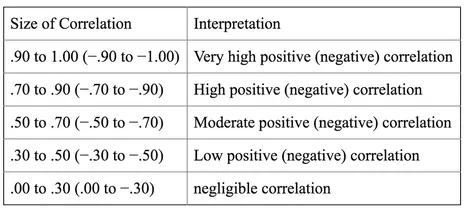

[Fonte: Everything you need to know about interpreting correlations](https://towardsdatascience.com/eveything-you-need-to-know-about-interpreting-correlations-2c485841c0b8#:~:text=If%20the%20P%2Dvalue%20is%20bigger%20than%20the%20significance%20level,and%20y%20in%20the%20population%E2%80%9D)

In [75]:
# Seleciona dados acima da diagonal principal
dados_acima_diagonal_principal = correlacao.where(np.triu(np.ones(correlacao.shape), k=1).astype(bool))

# Retorna os nome (index) das colunas com correlção maior que o valor deifnido
nome_dados_acima_diagonal_principal = [column for column in dados_acima_diagonal_principal.columns \
                                       if any(dados_acima_diagonal_principal[column] > 0.6)]

nome_dados_acima_diagonal_principal

['NDVI_b02',
 'NDVI_b03',
 'NDVI_b04',
 'NDVI_b08',
 'NDVI_b09',
 'NDVI_b10',
 'NDVI_b11',
 'NDVI_b12',
 'mil_tonelada_cana']

In [76]:
dados_acima_diagonal_principal[nome_dados_acima_diagonal_principal]

,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
bloco,-0.16,-0.14,-0.10,0.16,0.14,0.15,0.20,0.14,-0.03
talhao,0.00,0.03,0.01,-0.09,-0.13,-0.12,-0.15,-0.11,-0.04
area,-0.04,-0.01,0.01,0.01,-0.00,0.00,-0.01,-0.01,0.65
NDVI_b01,0.79,0.72,0.47,-0.38,-0.39,-0.20,-0.03,0.05,0.21
NDVI_b02,NaN,0.77,0.66,-0.36,-0.34,-0.30,-0.09,0.03,0.23
NDVI_b03,NaN,NaN,0.73,-0.27,-0.31,-0.30,-0.19,-0.03,0.28
NDVI_b04,NaN,NaN,NaN,-0.13,-0.19,-0.21,-0.16,-0.06,0.30
NDVI_b05,NaN,NaN,NaN,0.23,0.10,0.05,-0.02,-0.01,0.21
NDVI_b06,NaN,NaN,NaN,0.41,0.26,0.16,0.02,-0.00,0.14
NDVI_b07,NaN,NaN,NaN,0.66,0.56,0.42,0.23,0.11,0.00


In [77]:
import itertools

# Cria as combinações de pares de features
combinacao = list(itertools.combinations(nome_dados_acima_diagonal_principal, 2))

significancia = 0.05

# alcula o coeficiente de correlação de Pearson e o p-valor para ca da combinação
for pair in combinacao:
    coef_pearson, p_value = pearsonr(X_2014_2018[pair[0]], X_2014_2018[pair[1]])

    if p_value < significancia:
        print(f'\n{pair}: p_valor {p_value:.4f} < {significancia}')
        print('A correlação É estatisticamente significante')
        print(f'Coeficiente de correlação: {coef_pearson:.2f}')

    # else:
    #     print(f'\n{pair}: p_valor {p_value:.4f} > {significancia}')
    #     print('A correlação NÃO é estatisticamente significante')


('NDVI_b02', 'NDVI_b03'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: 0.77

('NDVI_b02', 'NDVI_b04'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: 0.66

('NDVI_b02', 'NDVI_b08'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: -0.36

('NDVI_b02', 'NDVI_b09'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: -0.34

('NDVI_b02', 'NDVI_b10'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: -0.30

('NDVI_b02', 'NDVI_b11'): p_valor 0.0003 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: -0.09

('NDVI_b02', 'mil_tonelada_cana'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente de correlação: 0.23

('NDVI_b03', 'NDVI_b04'): p_valor 0.0000 < 0.05
A correlação É estatisticamente significante
Coeficiente

## Fator de inflação da variância

In [78]:
df_vif = pd.DataFrame()

df_vif['feature'] = X_2014_2018.columns

df_vif['variance_inflation_factor'] = [variance_inflation_factor(X_2014_2018, i) for i in range(X_2014_2018.shape[1])]


fig = go.Figure(go.Bar(y=df_vif['feature'],
                       x=df_vif['variance_inflation_factor'],
                       name='Variance inflation factor',
                       orientation='h',
                       text=round(df_vif['variance_inflation_factor'], 2),
                       textfont=dict(size=12,
                                     color='black'),
                       marker_color='#9713FF'))


fig.update_layout(height=800,
                  width=800,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Fator de inflação da variância',
                  yaxis={'categoryorder':'total ascending',
                         'showgrid': False},
                  xaxis={'showgrid': False,
                         'showticklabels': True})

fig.update_traces(textangle=0, textposition='outside', cliponaxis=False)

#### Scaler

In [79]:
scaler = StandardScaler()

X_2014_2018_scaled = scaler.fit_transform(X_2014_2018)

In [80]:
df_vif_scaled = pd.DataFrame()

df_vif_scaled['feature'] = X_2014_2018.columns

df_vif_scaled['variance_inflation_factor'] = [variance_inflation_factor(X_2014_2018_scaled, i) for i in range(X_2014_2018_scaled.shape[1])]


fig = go.Figure(go.Bar(y=df_vif_scaled['feature'],
                       x=df_vif_scaled['variance_inflation_factor'],
                       name='Variance inflation factor',
                       orientation='h',
                       text=round(df_vif_scaled['variance_inflation_factor'], 2),
                       textfont=dict(size=12,
                                     color='black'),
                       marker_color='#9713FF'))


fig.update_layout(height=800,
                  width=800,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Fator de inflação da variância<br>Fatures redimensionadas',
                  yaxis={'categoryorder':'total ascending',
                         'showgrid': False},
                  xaxis={'showgrid': False,
                         'showticklabels': False})

fig.update_traces(textangle=0, textposition='outside', cliponaxis=True)

One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

[Fonte: Documentação StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

## 2019

In [81]:
df_2019 = df[df['safra'] == 2019].copy()

df_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,0.716843,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819,NaN
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,0.729465,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366,NaN
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,0.696446,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920,NaN
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,0.619985,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304,NaN
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,0.556784,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,0.676819,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,0.548335,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,0.724634,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,0.783614,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN


In [82]:
df_2019.drop(columns=['bloco', 'talhao', 'area', 'safra']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TCH,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NDVI_b01,274.0,0.587152,0.099383,0.276045,0.509570,0.581890,0.666902,0.778111
NDVI_b02,274.0,0.646495,0.076851,0.448785,0.586182,0.653024,0.707666,0.794342
NDVI_b03,274.0,0.683608,0.063981,0.394871,0.648020,0.691365,0.728785,0.796078
NDVI_b04,274.0,0.691888,0.063898,0.420401,0.670486,0.704398,0.732253,0.803938
NDVI_b05,274.0,0.684653,0.065286,0.445764,0.647462,0.691854,0.733240,0.822344
NDVI_b06,274.0,0.642602,0.088167,0.351739,0.601823,0.653424,0.707316,0.792112
NDVI_b07,274.0,0.620426,0.079398,0.371902,0.569703,0.623433,0.682723,0.806017
NDVI_b08,274.0,0.552268,0.105020,0.303599,0.467617,0.556688,0.635983,0.803671
NDVI_b09,274.0,0.469492,0.102848,0.293587,0.387774,0.453070,0.529979,0.751044


# b)

Desenvolva um modelo capaz de prever o TCH dos blocos do dataset para a safra de 2019 (atenção que a previsão deve ser no nível de blocos e não de talhões).

## Train test split

In [83]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_2014_2018,
                                                        y_2014_2018,
                                                        test_size=0.3,
                                                        random_state=seed)

print('\nShape do X_treino: ', X_treino.shape)
print('Shape do y_treino: ', y_treino.shape)

print('\nShape do X_teste: ', X_teste.shape)
print('Shape do y_teste: ', y_teste.shape)


Shape do X_treino:  (1142, 16)
Shape do y_treino:  (1142, 1)

Shape do X_teste:  (490, 16)
Shape do y_teste:  (490, 1)


In [84]:
X_treino_scaled = scaler.fit_transform(X_treino)

X_teste_scaled = scaler.transform(X_teste)

In [85]:
X_2019 = df_2019[features]

y_2019 = df_2019[target]

print('\nShape do X_2019: ', X_2019.shape)
print('Shape do y_2019: ', y_2019.shape)


Shape do X_2019:  (274, 16)
Shape do y_2019:  (274, 1)


In [86]:
X_2019_scaled = scaler.transform(X_2019)

In [87]:
X_2019_scaled

array([[ 1.19765505, -0.72968125,  0.82084762, ...,  0.30258042,
         0.45063897,         nan],
       [ 0.76597079, -0.72968125,  1.67995924, ...,  0.84565602,
         1.418351  ,         nan],
       [ 0.76597079, -0.27949433,  0.15985837, ...,  0.33178854,
         0.73948103,         nan],
       ...,
       [ 1.62202262, -0.72968125,  0.81840597, ..., -0.08490766,
        -0.61520278,         nan],
       [ 0.51720359, -0.72968125,  1.57950283, ...,  1.28296882,
         1.26348279,         nan],
       [ 1.13912159, -0.50458779, -1.56673625, ...,  0.31962597,
         0.52482482,         nan]])

Aplica-se .fit_transform() em X_treino enquanto usamos .transform() em X_test.

Isso é feito para dimensionar o conjunto de teste com os mesmos parâmetros do conjunto de treinamento, mas evitar vazamento de dados.

fit_transform calcula os valores de escala e os aplica, enquanto .transform apenas aplica os valores calculados.

## XGBoost

In [88]:
t1_xgbr_teste = time.perf_counter()


# Modelo XGBoost Regressor
modelo_xgbr = xgb.XGBRegressor(eval_metric=['mae', 'rmse'],
                               random_state=seed)

eval_set = [(X_treino_scaled, y_treino), (X_teste_scaled, y_teste)]

params_xgbr = {'n_estimators':  [300, 400, 500, 600],
               'learning_rate': [0.1, 0.01, 0.001],
               'booster':       ['dart', 'gbtree'],  # Tree based models
               'objective':     ['reg:squarederror']}


# Random search dos melhores parametros
xgbr_rand_search = RandomizedSearchCV(modelo_xgbr,
                                      param_distributions=params_xgbr,
                                      n_iter=5,
                                      cv=5,  # Cross-validation
                                      scoring='neg_mean_squared_error',
                                      error_score='raise',
                                      verbose=3,
                                      random_state=seed)

xgbr_rand_search.fit(X_treino_scaled, y_treino)


# Define o modelo XGBRegressor com melhores parâmetros
melhor_xgbr_regressor = xgbr_rand_search.best_estimator_

melhor_xgbr_regressor.fit(X_treino_scaled,
                          y_treino,
                          verbose=False,
                          eval_set=eval_set)

pred_xgbr_teste = melhor_xgbr_regressor.predict(X_teste_scaled)

pred_xgbr_teste = pd.Series(pred_xgbr_teste, index=y_teste.index)


t2_xgbr_teste = time.perf_counter()
tempo_total_xgbr_teste = t2_xgbr_teste - t1_xgbr_teste
print(f'Tempo de execução: {tempo_total_xgbr_teste:.2f} segundos')
print(f'Tempo de execução: {(tempo_total_xgbr_teste) / 60:.2f} minutos')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END booster=dart, learning_rate=0.001, n_estimators=600, objective=reg:squarederror;, score=-306.691 total time=  45.1s
[CV 2/5] END booster=dart, learning_rate=0.001, n_estimators=600, objective=reg:squarederror;, score=-273.435 total time=  44.2s
[CV 3/5] END booster=dart, learning_rate=0.001, n_estimators=600, objective=reg:squarederror;, score=-333.286 total time=  43.7s
[CV 4/5] END booster=dart, learning_rate=0.001, n_estimators=600, objective=reg:squarederror;, score=-376.379 total time=  45.0s
[CV 5/5] END booster=dart, learning_rate=0.001, n_estimators=600, objective=reg:squarederror;, score=-296.516 total time=  43.7s
[CV 1/5] END booster=dart, learning_rate=0.001, n_estimators=500, objective=reg:squarederror;, score=-360.709 total time=  33.3s
[CV 2/5] END booster=dart, learning_rate=0.001, n_estimators=500, objective=reg:squarederror;, score=-321.254 total time=  30.3s
[CV 3/5] END booster=dart, learning_r

In [89]:
results = melhor_xgbr_regressor.evals_result()

rmse_treino = results['validation_0']['rmse']

rmse_teste = results['validation_1']['rmse']

df_rmse_treino = pd.DataFrame(data=rmse_treino, columns=['rmse_treino'])

df_rmse_teste = pd.DataFrame(data=rmse_teste, columns=['rmse_teste'])

In [90]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=df_rmse_treino.index, y=df_rmse_treino['rmse_treino'],
                         mode='lines',
                         name='RMSE Treino'))

fig.add_trace(go.Scatter(x=df_rmse_teste.index, y=df_rmse_teste['rmse_teste'],
                         mode='lines',
                         name='RMSE Teste'))

fig.update_layout(height=400,
                  width=1000,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Análise de overfitting/underfitting XGBRegressor',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'},
                  xaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'})

In [91]:
mae_treino = results['validation_0']['mae']

mae_teste = results['validation_1']['mae']

df_mae_treino = pd.DataFrame(data=mae_treino, columns=['mae_treino'])

df_mae_teste = pd.DataFrame(data=mae_teste, columns=['mae_teste'])

In [92]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=df_mae_treino.index, y=df_mae_treino['mae_treino'],
                         mode='lines',
                         name='MAE Treino'))

fig.add_trace(go.Scatter(x=df_mae_teste.index, y=df_mae_teste['mae_teste'],
                         mode='lines',
                         name='MAE Teste'))

fig.update_layout(height=400,
                  width=1000,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Análise de overfitting/underfitting XGBRegressor',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'},
                  xaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'})

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

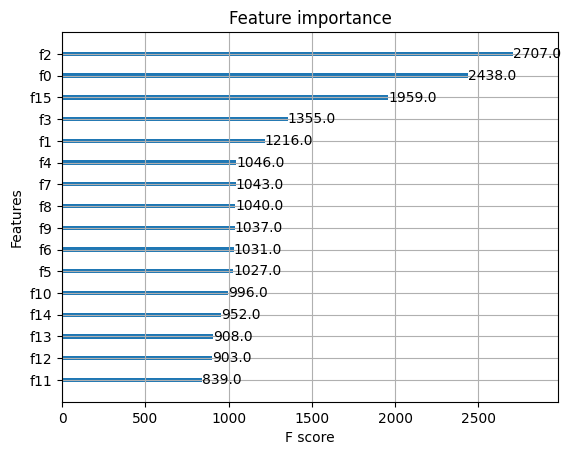

In [93]:
plot_importance(melhor_xgbr_regressor)

In [94]:
xgbr_rand_search.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 500,
 'learning_rate': 0.1,
 'booster': 'gbtree'}

In [95]:
pred_xgbr_teste

1336     76.365059
587      62.187752
602     101.974861
527      81.077530
76       95.982101
           ...    
330      26.823605
1010     55.714607
1038     47.535297
1624     46.916943
56      127.860703
Length: 490, dtype: float32

In [96]:
# Métricas de avaliacao
rmse_xgbr_teste = mean_squared_error(y_teste, pred_xgbr_teste.values, squared=False)
rmse_xgbr_teste = round(rmse_xgbr_teste, 2)
print(f'RMSE XGBoost teste: {rmse_xgbr_teste}')

mae_xgbr_teste = mean_absolute_error(y_teste, pred_xgbr_teste.values)
mae_xgbr_teste = round(mae_xgbr_teste, 2)
print(f'MAE XGBoost teste: {mae_xgbr_teste}')

max_error_xgbr_teste = max_error(y_teste, pred_xgbr_teste.values)
max_error_xgbr_teste = round(max_error_xgbr_teste, 2)
print(f'Max error XGBoost teste: {max_error_xgbr_teste}')

mape_xgbr_teste = mean_absolute_percentage_error(y_teste, pred_xgbr_teste.values) * 100
mape_xgbr_teste = round(mape_xgbr_teste, 2)
print(f'MAPE XGBoost teste: {rmse_xgbr_teste}%')

r2_score_xgbr_teste = r2_score(y_teste, pred_xgbr_teste.values) * 100
r2_score_xgbr_teste = round(r2_score_xgbr_teste, 2)
print(f'R2 XGBoost teste: {r2_score_xgbr_teste}%')

RMSE XGBoost teste: 2.65
MAE XGBoost teste: 1.83
Max error XGBoost teste: 14.15
MAPE XGBoost teste: 2.65%
R2 XGBoost teste: 99.19%


In [97]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=y_teste.index, y=y_teste['TCH'],
                         mode='markers',
                         name='TCH_teste'))

fig.add_trace(go.Scatter(x=pred_xgbr_teste.index, y=pred_xgbr_teste,
                         mode='markers',
                         name='TCH_pred'))

fig.update_layout(height=400,
                  width=1000,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=10),
                  title='Correlação entre TCH_teste e TCH_teste_pred (XGBRegressor)',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'},
                  xaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'rangemode': 'tozero'})

### Pred TCH 2019

In [98]:
X_2019_scaled

array([[ 1.19765505, -0.72968125,  0.82084762, ...,  0.30258042,
         0.45063897,         nan],
       [ 0.76597079, -0.72968125,  1.67995924, ...,  0.84565602,
         1.418351  ,         nan],
       [ 0.76597079, -0.27949433,  0.15985837, ...,  0.33178854,
         0.73948103,         nan],
       ...,
       [ 1.62202262, -0.72968125,  0.81840597, ..., -0.08490766,
        -0.61520278,         nan],
       [ 0.51720359, -0.72968125,  1.57950283, ...,  1.28296882,
         1.26348279,         nan],
       [ 1.13912159, -0.50458779, -1.56673625, ...,  0.31962597,
         0.52482482,         nan]])

In [99]:
t1 = time.perf_counter()

pred_tch_2019_xgbr_regressor = melhor_xgbr_regressor.predict(X_2019_scaled)

pred_tch_2019_xgbr_regressor = pd.Series(pred_tch_2019_xgbr_regressor, index=y_2019.index)

y_2019['tch_xgbr_regressor'] = pred_tch_2019_xgbr_regressor

t2 = time.perf_counter()
print(f'Tempo de execução: {t2-t1:.2f} segundos')
print(f'Tempo de execução: {(t2-t1) / 60:.2f} minutos')

Tempo de execução: 0.01 segundos
Tempo de execução: 0.00 minutos


In [100]:
y_2019

,TCH,tch_xgbr_regressor
1632,NaN,134.701782
1633,NaN,128.658539
1634,NaN,140.119324
1635,NaN,138.142136
1636,NaN,143.514175
...,...,...
1901,NaN,144.893814
1902,NaN,145.043396
1903,NaN,139.144943
1904,NaN,132.897430


## Coleta de resultados

In [101]:
tch_xgbr_regressor = pd.concat([df_2014_2018['TCH'], y_2019['tch_xgbr_regressor']], axis=0)

In [102]:
df_2014_2019 = df.copy()

df_2014_2019['tch_xgbr_regressor'] = tch_xgbr_regressor

df_2014_2019['mil_tonelada_cana_xgbr_regressor'] = df_2014_2019['area'] * df_2014_2019['tch_xgbr_regressor'] / 1000

df_2014_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,tch_xgbr_regressor,mil_tonelada_cana_xgbr_regressor
0,8,3,94.81,2014,2014-04-09,69.645161,0.725766,0.715820,0.682476,0.767984,...,0.616645,0.577776,0.673877,0.717980,0.680429,0.392738,0.342305,6.603058,69.645161,6.603058
1,8,1,101.56,2014,2014-04-09,75.522509,0.753956,0.766079,0.729128,0.753687,...,0.662919,0.591849,0.678728,0.737391,0.695298,0.480172,0.681477,7.670066,75.522509,7.670066
2,8,2,72.35,2014,2014-04-09,93.504762,0.752384,0.750748,0.705740,0.735009,...,0.596097,0.609360,0.661331,0.753325,0.734820,0.512713,0.677876,6.765070,93.504762,6.765070
3,8,11,59.66,2014,2014-04-14,51.913213,0.706813,0.734599,0.740032,0.779675,...,0.644113,0.671033,0.584503,0.723824,0.635757,0.456810,0.514389,3.097142,51.913213,3.097142
4,204,2,79.13,2014,2014-05-01,113.746898,0.735687,0.762101,0.754390,0.768549,...,0.690370,0.638113,0.541806,0.571890,0.547047,0.346916,0.220534,9.000792,113.746898,9.000792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN,144.893814,8.641467
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN,145.043396,6.041057
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN,139.144943,14.391761
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN,132.897430,16.645403


In [103]:
df_2014_2019_agrupado_bloco = df_2014_2019.groupby(['safra', 'bloco']).sum()

df_2014_2019_agrupado_bloco.reset_index(drop=False, inplace=True)

df_2014_2019_agrupado_bloco

<ipython-input-103-c6482cb4bd12>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,safra,bloco,talhao,area,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,tch_xgbr_regressor,mil_tonelada_cana_xgbr_regressor
0,2014,5,11,64.51,139.887515,0.503641,0.579957,0.574858,0.697860,0.764207,0.747308,0.751626,0.712636,0.729812,0.638457,0.575405,0.602794,9.024144,139.887515,9.024144
1,2014,8,17,328.38,290.585646,2.938919,2.967247,2.857376,3.036355,2.539453,2.519774,2.450018,2.598440,2.932520,2.746304,1.842433,2.216047,24.135336,290.585646,24.135336
2,2014,11,4,97.08,111.121047,0.467212,0.426860,0.541768,0.555536,0.605176,0.696887,0.697468,0.671822,0.626946,0.622548,0.564925,0.502727,10.787631,111.121047,10.787631
3,2014,12,6,215.81,339.957327,1.632772,1.613185,1.977937,2.122541,2.031348,2.029820,1.984027,2.102951,1.878264,1.637450,1.364316,1.073405,27.389096,339.957327,27.389096
4,2014,13,1,67.28,83.022048,0.440241,0.441936,0.479479,0.524397,0.656918,0.720285,0.688459,0.688926,0.650357,0.598879,0.576207,0.560059,5.585723,83.022048,5.585723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,2019,463,21,552.85,0.000000,2.479996,3.166682,3.447394,4.088144,4.343657,3.483643,4.093422,3.612785,3.508883,2.524095,2.055733,1.802740,0.000000,840.838821,76.570205
705,2019,464,6,264.29,0.000000,2.031889,2.246860,1.817471,2.187716,1.965861,2.011033,1.503895,1.250442,1.482647,1.725189,1.862911,1.667356,0.000000,416.457169,36.254276
706,2019,468,12,150.14,0.000000,2.230861,2.251037,2.300944,1.710271,2.304834,1.894286,1.909624,1.337930,1.050307,1.252623,1.481919,1.501413,0.000000,430.508514,21.558117
707,2019,473,3,219.79,0.000000,0.897920,1.156609,1.346961,1.518553,1.454349,1.469960,1.432192,1.402224,1.316593,0.976624,0.668293,0.724418,0.000000,271.389786,29.700444


In [104]:
for safra in df_2014_2019_agrupado_bloco['safra'].unique():
    df_safra_bloco = df_2014_2019_agrupado_bloco[df_2014_2019_agrupado_bloco['safra'] == safra]

    quantidade_blocos = df_safra_bloco['bloco'].value_counts().sum()

    if safra != 2019:

        milhao_tonelada_safra = df_safra_bloco['mil_tonelada_cana'].sum() / 1000
        produtividade_media_bloco = df_safra_bloco['mil_tonelada_cana'].sum() / quantidade_blocos

    milhao_tonelada_safra = df_safra_bloco['mil_tonelada_cana_xgbr_regressor'].sum() / 1000
    produtividade_media_bloco = df_safra_bloco['mil_tonelada_cana_xgbr_regressor'].sum() / quantidade_blocos

    print(f'\nSafra: {safra} - Blocos: {quantidade_blocos} - Total produzido: {milhao_tonelada_safra:.2f} milhões toneladas - Produtividade média por bloco: {produtividade_media_bloco:.2f} mil toneladas')


Safra: 2014 - Blocos: 154 - Total produzido: 2.27 milhões toneladas - Produtividade média por bloco: 14.72 mil toneladas

Safra: 2015 - Blocos: 53 - Total produzido: 0.65 milhões toneladas - Produtividade média por bloco: 12.27 mil toneladas

Safra: 2016 - Blocos: 27 - Total produzido: 0.34 milhões toneladas - Produtividade média por bloco: 12.47 mil toneladas

Safra: 2017 - Blocos: 188 - Total produzido: 3.14 milhões toneladas - Produtividade média por bloco: 16.69 mil toneladas

Safra: 2018 - Blocos: 172 - Total produzido: 3.45 milhões toneladas - Produtividade média por bloco: 20.07 mil toneladas

Safra: 2019 - Blocos: 115 - Total produzido: 3.02 milhões toneladas - Produtividade média por bloco: 26.30 mil toneladas


In [105]:
df_2014_2019_agrupado_bloco[df_2014_2019_agrupado_bloco['safra'] == 2019]

,safra,bloco,talhao,area,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,NDVI_b05,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,tch_xgbr_regressor,mil_tonelada_cana_xgbr_regressor
594,2019,13,1,67.28,0.0,0.688200,0.718599,0.732889,0.700157,0.702455,0.479158,0.550311,0.444463,0.409690,0.427989,0.486711,0.501093,0.0,143.158325,9.631692
595,2019,16,1,31.34,0.0,0.561317,0.611405,0.674954,0.662746,0.665600,0.525441,0.595787,0.593090,0.375706,0.471425,0.384695,0.375208,0.0,145.951752,4.574128
596,2019,17,21,432.42,0.0,3.999530,4.166051,4.156167,3.959398,3.891229,2.797747,3.517707,2.739435,2.409677,2.380063,2.830045,2.980745,0.0,850.927338,60.869548
597,2019,19,1,94.64,0.0,0.557562,0.622865,0.743437,0.764749,0.750387,0.686653,0.688869,0.626937,0.370526,0.477837,0.326793,0.303321,0.0,139.319733,13.185219
598,2019,20,3,128.85,0.0,1.138048,1.223652,1.463459,1.500162,1.481539,1.377236,1.444101,1.322068,0.748208,0.753024,0.726219,0.660565,0.0,281.601654,18.015504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,2019,463,21,552.85,0.0,2.479996,3.166682,3.447394,4.088144,4.343657,3.483643,4.093422,3.612785,3.508883,2.524095,2.055733,1.802740,0.0,840.838821,76.570205
705,2019,464,6,264.29,0.0,2.031889,2.246860,1.817471,2.187716,1.965861,2.011033,1.503895,1.250442,1.482647,1.725189,1.862911,1.667356,0.0,416.457169,36.254276
706,2019,468,12,150.14,0.0,2.230861,2.251037,2.300944,1.710271,2.304834,1.894286,1.909624,1.337930,1.050307,1.252623,1.481919,1.501413,0.0,430.508514,21.558117
707,2019,473,3,219.79,0.0,0.897920,1.156609,1.346961,1.518553,1.454349,1.469960,1.432192,1.402224,1.316593,0.976624,0.668293,0.724418,0.0,271.389786,29.700444


In [106]:
df_safras_tch = pd.DataFrame(df_2014_2019.groupby('safra')[['mil_tonelada_cana_xgbr_regressor',
                                                            'tch_xgbr_regressor']].sum())

df_safras_tch.reset_index(drop=False, inplace=True)

df_safras_tch['mil_tch_xgbr_regressor'] = df_safras_tch['tch_xgbr_regressor'] / 1000

df_safras_tch['milhao_tonelada_cana_xgbr_regressor'] = df_safras_tch['mil_tonelada_cana_xgbr_regressor'] / 1000

df_safras_tch

,safra,mil_tonelada_cana_xgbr_regressor,tch_xgbr_regressor,mil_tch_xgbr_regressor,milhao_tonelada_cana_xgbr_regressor
0,2014,2267.336283,27877.678743,27.877679,2.267336
1,2015,650.105849,8294.836061,8.294836,0.650106
2,2016,336.794911,4160.731266,4.160731,0.336795
3,2017,3137.442989,38653.503679,38.653504,3.137443
4,2018,3452.381182,43796.391863,43.796392,3.452381
5,2019,3024.164426,38477.306976,38.477307,3.024164


In [107]:
fig = px.line(df_safras_tch, x='safra', y='milhao_tonelada_cana_xgbr_regressor',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_tch['milhao_tonelada_cana_xgbr_regressor'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='Produção total de cana (em milhões de toneladas)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

## Análise gráfica

### XGBRegressor

In [108]:
fig = px.box(df_2014_2019,
             y='tch_xgbr_regressor',
             x='safra',
             color='safra',
             color_discrete_sequence=['#1738FE',
                                      '#A2A1D1',
                                      '#1A9BFD',
                                      '#9713FF',
                                      '#167BFC'])

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='Variação do TCH (2019 por XGBRegressor)',
                  yaxis={'showgrid': True,
                         'title': '',
                         'dtick': 25,
                         'gridcolor': '#CBC9CD'},
                  xaxis={'showgrid': False,
                         'title': ''})

In [118]:
df_2019_agrupado_bloco = df_2014_2019_agrupado_bloco[df_2014_2019_agrupado_bloco['safra'] == 2019]

In [203]:
df_2019_agrupado_bloco['bloco'] = df_2019_agrupado_bloco['bloco'].astype(str)

fig = px.bar(df_2019_agrupado_bloco[:], x='bloco', y='tch_xgbr_regressor',
             color_discrete_sequence=['#1738FE'],
             text=round(df_2019_agrupado_bloco['tch_xgbr_regressor'], 2))

fig.update_traces(width=1,
                  textangle=-60,
                  textposition='outside',
                  textfont={'color': 'black', 'size': 32},
                  cliponaxis=False)

fig.update_layout(height=720,
                  width=1280,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por bloco em 2019 (XGBRegressor)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'dtick': 100},
                  xaxis={'showgrid': False,
                         'title': 'Bloco',
                         'dtick': 1})

In [110]:
fig = px.line(df_safras_tch, x='safra', y='mil_tch_xgbr_regressor',
              color_discrete_sequence=['#9713FF'],
              markers=True,
              text=round(df_safras_tch['mil_tch_xgbr_regressor'], 2))

fig.update_layout(height=500,
                  width=1200,
                  showlegend=False,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=80,
                              pad=0),
                  title='TCH por safra em mil toneladas (2019 por XGBRegressor)',
                  yaxis={'showgrid': False,
                         'title':'',
                         'visible': False},
                  xaxis={'showgrid': True,
                         'title': '',
                         'dtick': 1,
                         'gridcolor': '#CBC9CD'})

fig.update_traces(marker={'size': 12}, textposition='top center')

## Análise entre estimativas de safra 2019

In [111]:
df_tch_2019 = df_2014_2019[df_2014_2019['safra'] == 2019]

df_tch_2019

,bloco,talhao,area,safra,data_colheita,TCH,NDVI_b01,NDVI_b02,NDVI_b03,NDVI_b04,...,NDVI_b06,NDVI_b07,NDVI_b08,NDVI_b09,NDVI_b10,NDVI_b11,NDVI_b12,mil_tonelada_cana,tch_xgbr_regressor,mil_tonelada_cana_xgbr_regressor
1632,390,1,103.50,2019,2019-04-30,NaN,0.766172,0.787150,0.695758,0.759053,...,0.734790,0.626217,0.465695,0.478633,0.479459,0.513778,0.477819,NaN,134.701782,13.941634
1633,331,1,128.13,2019,2019-05-01,NaN,0.717628,0.732776,0.603192,0.789992,...,0.759854,0.615914,0.446501,0.536692,0.603979,0.578049,0.585366,NaN,128.658539,16.485019
1634,331,3,84.55,2019,2019-05-01,NaN,0.664377,0.704836,0.528287,0.737376,...,0.720576,0.593769,0.417800,0.477775,0.529074,0.517235,0.509920,NaN,140.119324,11.847089
1635,211,3,66.02,2019,2019-05-03,NaN,0.671532,0.694715,0.394871,0.638976,...,0.691832,0.586141,0.418271,0.391056,0.393528,0.346410,0.328304,NaN,138.142136,9.120144
1636,402,2,56.66,2019,2019-05-03,NaN,0.707852,0.736049,0.607036,0.631825,...,0.505431,0.371902,0.342388,0.295912,0.294306,0.285887,0.280886,NaN,143.514175,8.131513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,298,1,59.64,2019,2019-08-15,NaN,0.394406,0.574657,0.605176,0.714840,...,0.647512,0.780316,0.768681,0.547546,0.662882,0.481820,0.520789,NaN,144.893814,8.641467
1902,36,1,41.65,2019,2019-08-16,NaN,0.566719,0.653298,0.701193,0.694102,...,0.425905,0.735258,0.623934,0.470607,0.710095,0.402332,0.478802,NaN,145.043396,6.041057
1903,448,1,103.43,2019,2019-08-16,NaN,0.419522,0.487945,0.637735,0.717915,...,0.733154,0.672781,0.673923,0.607410,0.537483,0.467920,0.359367,NaN,139.144943,14.391761
1904,297,1,125.25,2019,2019-08-16,NaN,0.540118,0.523605,0.482602,0.605112,...,0.781636,0.806017,0.803671,0.524437,0.689516,0.629803,0.568155,NaN,132.897430,16.645403


In [112]:
layout = go.Layout(legend={'orientation': 'h',
                           'yanchor': 'top',
                           'y': 1.1,
                           'xanchor': 'left',
                           'x': 0})

fig = go.Figure(layout=layout)

fig.add_trace(go.Box(y=df_tch_2019['tch_xgbr_regressor'],
                     name='XGBRegressor',
                     marker_color='#1738FE'))

fig.update_layout(height=500,
                  width=500,
                  showlegend=True,
                  plot_bgcolor='#F9F9F9',
                  paper_bgcolor='#F9F9F9',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=100,
                              pad=0),
                  title='Variação do TCH estimado para 2019',
                  yaxis={'showgrid': True,
                         'gridcolor': '#CBC9CD',
                         'dtick': 10},
                  xaxis={'showgrid': False,
                         'gridcolor': '#CBC9CD'})

# c)
Qual o erro esperado do modelo para a safra de 2019? Utilize a métrica de erro que você julgar necessária, podendo ser utilizada mais de uma.

**RMSE**

Is used to measure the deviation between predicted and observed values.

The RMSE is calculated to correlate with larger values and is more sensitive to outliers.

**MAE**

Gives a good indication of the actual situation of the error in the predicted values.

**MAPE**

Indicates the average deviation between the predicted and observed values.

---

The smaller the MAPE, RMSE and MAE values, the better the prediction performance of the model and the higher the prediction accuracy.

## Métricas

In [113]:
metricas = [[rmse_xgbr_teste, mae_xgbr_teste, max_error_xgbr_teste,
             mape_xgbr_teste, r2_score_xgbr_teste, tempo_total_xgbr_teste]]

colunas = ['rmse', 'mae', 'max_error', 'mape', 'r2_score', 'tempo_total_teste']

index = ['XGBRegressor<br>teste']

df_metricas = pd.DataFrame(data=metricas,
                           columns=colunas,
                           index=index)

df_metricas['mil_tch_pred_2019'] = None

df_metricas['mil_tch_pred_2019'].iloc[0] = df_safras_tch['mil_tch_xgbr_regressor'].iloc[-1].round(2)

df_metricas

,rmse,mae,max_error,mape,r2_score,tempo_total_teste,mil_tch_pred_2019
XGBRegressor<br>teste,2.65,1.83,14.15,3.24,99.19,417.637966,38.48


## Análise gráfica

In [132]:
fig = make_subplots(rows=4, cols=2,
                    subplot_titles=('RMSE', 'MAE',
                                    'Max error', 'MAPE (%)',
                                    'R2 score (%)', 'Tempo de teste (segundos)',
                                    'Mil TCH para 2019'),
                    horizontal_spacing = 0.05,
                    vertical_spacing = 0.1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['rmse'],
                     text=df_metricas['rmse'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#1738FE',
                             'line.width': 0}),
              row=1, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['mae'],
                     text=df_metricas['mae'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#57DCFF',
                             'line.width': 0}),
              row=1, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['max_error'],
                     text=df_metricas['max_error'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#B7DCFE',
                             'line.width': 0}),
              row=2, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['mape'],
                     text=df_metricas['mape'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#9713FF',
                             'line.width': 0}),
              row=2, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['r2_score'],
                     text=df_metricas['r2_score'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#9713FF',
                             'line.width': 0}),
              row=3, col=1)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['tempo_total_teste'],
                     text=df_metricas['tempo_total_teste'].round(2),
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#167BFC',
                             'line.width': 0}),
              row=3, col=2)

fig.add_trace(go.Bar(x=df_metricas.index,
                     y=df_metricas['mil_tch_pred_2019'],
                     text=df_metricas['mil_tch_pred_2019'],
                     textfont=dict(size=16, color='black'),
                     marker={'color': '#1A9BFD',
                             'line.width': 0}),
              row=4, col=1)

fig.update_layout(height=900,
                  width=500,
                  showlegend=False,
                  plot_bgcolor='#E0E0E0',
                  paper_bgcolor='#F9F9F9',
                  title='Análise de métricas',
                  margin=dict(l=50,
                              r=50,
                              b=50,
                              t=50,
                              pad=0))

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=1, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=1, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=2, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=2, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=3, col=1)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=3, col=2)

fig.update_yaxes({'showgrid': False,
                  'visible': False},
                 row=4, col=1)